In [1]:
# 📦 Étape 1 : Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm

import datetime

In [2]:
# 📁 Étape 2 : Chargement des données
df = pd.read_csv("full_data_fusionne.csv")

# 👀 Aperçu
print(df.head())
print(df.columns)

      source                                              title  \
0  France_24  الألعاب الأولمبية: الملاكمة خليف تبلغ ربع النه...   
1  France_24  محطة أفريقيا في الألعاب الأولمبية بباريس: "خيم...   
2  France_24  تنديدا باغتيال هنية... مظاهرات مناهضة لإسرائيل...   
3  France_24  إسرائيل "تغتال" صحفيا ومصورا من قناة الجزيرة ف...   
4  France_24  خليل الحية عن اغتيال هنية.. هذه جريمة لا بد لم...   

                                                 url published_at  \
0  https://www.france24.com/ar/%D8%B1%D9%8A%D8%A7...   2024-08-01   
1  https://www.france24.com/ar/%D8%B1%D9%8A%D8%A7...   2024-08-01   
2  https://www.france24.com/ar/%D8%A7%D9%84%D8%B4...   2024-08-01   
3  https://www.france24.com/ar/%D9%81%D9%8A%D8%AF...   2024-08-01   
4  https://www.france24.com/ar/%D9%81%D9%8A%D8%AF...   2024-08-01   

                tags                                            content  
0              رياضة  تغلبت الملاكمة الجزائرية إيمان خليف على خصمتها...  
1              رياضة  موفد فرانس24

In [3]:
# 🧼 Étape 3 : Prétraitement du texte
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = str(text).strip()
    return text

df['title'] = df['title'].apply(clean_text)
df['content'] = df['content'].apply(clean_text)
df['full_text'] = df['title'] + " " + df['content']

# 🕰️ Traitement de la date
df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce')
df['timestamp'] = df['published_at'].astype(np.int64) // 10**9  # timestamp in seconds

In [ ]:
# 🧠 Étape 4 : Vectorisation BERT multilingue avec asafaya/bert-base-arabic

import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm
import os

# 🔧 Désactiver les widgets et les warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TQDM_DISABLE"] = "1"

# 📌 Charger le modèle arabe BERT
model_name = "asafaya/bert-base-arabic"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()

# 🧾 Fonction d'embedding
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# ⏳ Vectorisation des textes
bert_vectors = []

for i, text in enumerate(tqdm(df['full_text'].tolist(), desc="Vectorisation BERT", ncols=100, leave=False)):
    try:
        emb = get_bert_embedding(text)
    except Exception as e:
        print(f"Erreur à la ligne {i}: {e}")
        emb = np.zeros(768)  # vecteur neutre en cas d’erreur
    bert_vectors.append(emb)

bert_vectors = np.array(bert_vectors)


Vectorisation BERT:   0%|                                                 | 0/41554 [00:00<?, ?it/s]

In [ ]:
# 🧮 Étape 5 : Encodage des autres colonnes
other_features = pd.DataFrame()

# Tags (textuels)
if 'tags' in df.columns:
    df['tags'] = df['tags'].fillna("")
    other_features['tags'] = df['tags']

# Encodage OneHot
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(other_features)

In [ ]:
# 🎛️ Étape 6 : Combinaison et pondération
# On va accorder plus de poids au BERT (titre + contenu) et à la date
scaler = MinMaxScaler()
date_scaled = scaler.fit_transform(df[['timestamp']])

# Pondération
bert_weight = 3.0
date_weight = 2.0
other_weight = 1.0

combined_features = np.hstack([
    bert_vectors * bert_weight,
    date_scaled * date_weight,
    encoded_features * other_weight
])

In [ ]:
# 📊 Étape 7 : Clustering K-means
k = 3  # Choisir le nombre de clusters
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(combined_features)

In [ ]:
print(df['cluster'].value_counts().sort_index())


In [ ]:
# 📉 Étape 8 : Visualisation en 2D via PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_features)
df['pca_1'] = pca_result[:, 0]
df['pca_2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pca_1', y='pca_2', hue='cluster', palette='tab10')
plt.title("Clusters visualisés via PCA")
plt.show()

# 🧾 Étape 9 : Aperçu des résultats
print(df[['title', 'cluster']].head(20))

In [ ]:
from sklearn.metrics import silhouette_score

score = silhouette_score(combined_features, df['cluster'])
print(f"Silhouette Score: {score:.3f}")


In [ ]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(combined_features, df['cluster'])
print(f"Davies-Bouldin Score: {db_score:.3f}")


In [114]:
print(f"Inertia: {kmeans.inertia_:.3f}")


Inertia: 317781.385


k=2, silhouette_score=0.238
k=3, silhouette_score=0.240
k=4, silhouette_score=0.167
k=5, silhouette_score=0.175
k=6, silhouette_score=0.179
k=7, silhouette_score=0.177
k=8, silhouette_score=0.036
k=9, silhouette_score=0.038
k=10, silhouette_score=0.040
k=11, silhouette_score=0.034
k=12, silhouette_score=0.039
k=13, silhouette_score=0.042
k=14, silhouette_score=0.043
k=15, silhouette_score=0.041
k=16, silhouette_score=0.041
k=17, silhouette_score=0.039
k=18, silhouette_score=0.044
k=19, silhouette_score=0.043
k=20, silhouette_score=0.034
k=21, silhouette_score=0.029
k=22, silhouette_score=0.031
k=23, silhouette_score=0.031
k=24, silhouette_score=0.033
k=25, silhouette_score=0.028
k=26, silhouette_score=0.029
k=27, silhouette_score=0.029
k=28, silhouette_score=0.032
k=29, silhouette_score=0.031
k=30, silhouette_score=0.030
k=31, silhouette_score=0.030
k=32, silhouette_score=0.030
k=33, silhouette_score=0.029
k=34, silhouette_score=0.029
k=35, silhouette_score=0.030
k=36, silhouette_score

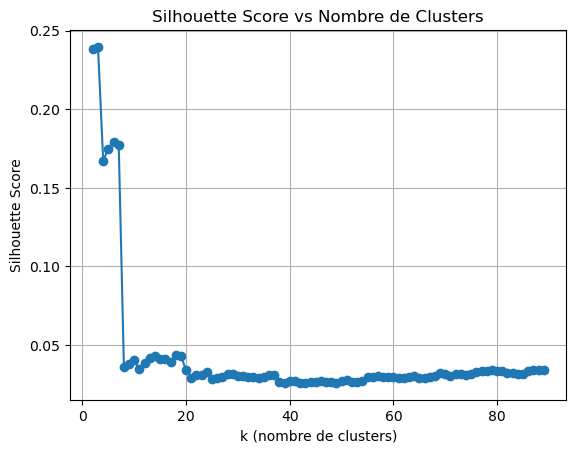

In [115]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

best_score = -1
best_k = 2
scores = []

# Tester k de 2 à 10
for k in range(2, 90):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(combined_features)
    score = silhouette_score(combined_features, labels)
    scores.append(score)
    
    print(f"k={k}, silhouette_score={score:.3f}")
    
    if score > best_score:
        best_score = score
        best_k = k

print(f"\n✅ Meilleur nombre de clusters : k={best_k} avec un score de {best_score:.3f}")
plt.plot(range(2, 90), scores, marker='o')
plt.title("Silhouette Score vs Nombre de Clusters")
plt.xlabel("k (nombre de clusters)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


In [116]:
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
df['cluster'] = final_kmeans.fit_predict(combined_features)


In [117]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)  # ou 50 selon le dataset
reduced_features = pca.fit_transform(combined_features)


In [118]:
kmeans = KMeans(n_clusters=15, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(combined_features)

In [119]:
score = silhouette_score(combined_features, df['cluster'])
print(f"Silhouette Score: {score:.3f}")


Silhouette Score: 0.040
